#### Some ideas:
* response time (b/w each "category" of petitions, individuals vs big companies,   
* count of big companies vs individuals
* type of requests being made
* success rate: type of requests being denied vs approved
* what specifically gets a petition denied/approved?

## Oct 8: Main goals after cleaning and visualizing data (revised from above):
* overall goal: to show that the FDA system is slow in order to support research paper about the consequences of FDA being slow

* do **inference modeling** on data to determine WHY do response times vary? is it bc of the submitter type or what their requests are?
  * y variable is response time, bigger coeff means those factors are strongly associated with response time 
  * Response_Time_Days = Intercept +/- (Coefficient * is_Individual) +/- (Coefficient * is_Industry) + ...
  * interpretation of model:
    * positive coeff: as this factor increases (or is present versus 0 coeff), the Response_Time_Days also increase (get longer), holding all other factors constant
    * negative coeff: as this factor increases (or is present), the Response_Time_Days tends to decrease (get shorter), holding all other factors constant
    * the bigger the coeff, the more impact that factor has on Response_Time_Days
  * will support research paper by adding a statistical foundation to show that the fda IS slow (bc of these certain factors), and this could lead to cases like Alliance for Hippocratic Medicine (AHM) vs FDA where the anti-abortion group was almost successful in getting the court to recall the abortion drug only because the FDA took too long to reply to their petition

* **make visualizations between final decisions and response time** to see if there is an association between certain response time and certain decisions
* e.g: lets say we find out long response time is associated with denials -> supports paper bc these delays lead to petitioners who are unsatisfied with final decision, so they will keep pushing their case, like how AHM was able to push their case bc of the delay

## OCT 22 Revised Plan: Inference Modeling with Cox Proportional Hazards

**Overall Goal:** Still the same – to provide statistical evidence supporting the research paper's argument about the consequences of FDA slowness by identifying factors associated with longer wait times

**Model Type: Cox Proportional Hazards (Cox PH) model** this model is designed for "time-to-event" data where some events (in this case final decisions) haven't happened yet (aka censored data)

**Key Variables:** instead of just one Y variable -> need two pieces of information for each petition:

1. **Duration:** The "Response Time (Days)" calculated (using the actual date for completed petitions and the imputed "end date" for censored ones); this is the total time the petition was observed
2. **Event:** a boolean column indicating whether the "event" (receiving a final decision) actually happened; add a boolean column "Received Final Decision" where 1 or True if final decision is 'withdrawn', 'denied', 'approved', or 'partially approved / denied', 'dismissed (moot)' else 0 or Flase if 'no decision'

**Model Output:**

* Cox PH model doesn't predict the time directly (compared to pevious)
* models the **hazard rate:** the instantaneous risk or probability of the event (getting a final decision) happening at any given time
* key outputs are hazard ratios (HR) associated with each feature (like "is_Individual", "is_Industry", etc.)

**Model Simplified**

Hazard Rate = Baseline_Hazard * exp( (Coef1 * is_Individual) + (Coef2 * is_Industry) + (Coef3 * OtherFeature) + ... )

* don't usually work with the output hazard rate directly -> focus on Hazard Ratios derived from the coefficients:

    Hazard Ratio for is_Individual = exp(Coef1)

    Hazard Ratio for is_Industry = exp(Coef2)

    Hazard Ratio for OtherFeature = exp(Coef3)

**Interpretation of Hazard Ratios (HR):** (different from OLS coefficients)

* model estimates coefficients (log-hazard ratios) -> usually exponentiate them (exp(coefficient)) to get the hazard ratio
* **HR = 1:** this factor has no effect on how quickly a decision is reached
* **HR > 1:** this factor *increases* the hazard rate ie. petitions with this factor tend to get a final decision faster (shorter wait times) compared to the baseline, holding other factors constant
* **HR < 1:** this factor *decreases* the hazard rate ie. petitions with this factor tend to get a final decision slower (longer wait times) compared to the baseline, holding other factors constant
* **magnitude:** the further the HR is from 1, the stronger the association
    * HR of 0.5: hazard is cut in half (takes roughly twice as long to get a decision) vs. HR of 2.0: hazard is doubled (takes roughly half as long)

**How it Supports Research Paper:** will look for factors with **HR significantly less than 1** (or even greater to get more info)

* ex: if the HR for "is_Individual" is 0.4, we can say:

    * "holding other factors constant, *petitions made by individuals have only 40% of the chance of receiving a final decision* at any given time compared to the baseline group" -> indicates a strong statistical association between being an individual petitioner and experiencing significantly longer delays
    * provides the statistical foundation showing who is most affected by the FDA's slowness, making them more likely candidates for the kind of legal action seen in the AHM case



In [1]:
%pip install seaborn
%pip install pandas
%pip install numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_csv("final_version_petitions_and_responses.csv")
df.head()

File ID                                 Petition File Name  \
0  fda-2017-p-0052  FDA-2017-P-0052-0001_Citizen_Petition_from_Don...   
1  fda-2017-p-0115  FDA-2017-P-0115-0001_Citizen_Petition_from_Jub...   
2  fda-2017-p-0137  FDA-2017-P-0137-0001_Citizen_Petition_from_Mac...   
3  fda-2017-p-0176  FDA-2017-P-0176-0001_Citizen_Petition_from_Ame...   
4  fda-2017-p-0290  FDA-2017-P-0290-0001_Citizen_Petition_from_Mal...   

  Date of Petition  Was_Withdrawn      Document Type  \
0       2017-01-01          False  original petition   
1       2016-12-22          False  original petition   
2       2017-01-09           True  original petition   
3       2017-01-09          False  original petition   
4       2017-01-17          False  original petition   

                                           Submitter        Submitter Type  \
0                             Donor Sibling Registry     advocacy/academic   
1                          Jubilant Generics Limited  industry/corporation   
2                   Macleods Pharmaceuticals Limited  industry/corporation   
3                  Kleinfeld, Kaplan and Becker, LLP        law/consulting   
4  Malaysian Rubber Export Promotion Council (MREPC)     advocacy/academic   

              Petition Cited Statutes or Regulations  \
0  - 21 C.F.R. § 10.20\n- 21 C.F.R. § 10.30\n- 21...   
1  - Section 505(j)(2)(C) of the FD&C Act [21 U.S...   
2  - Section 505(j) of the Federal Food, Drug, an...   
3  - 21 C.F.R. § 10.30 (Citizen Petition procedur...   
4  - FDA Docket No. FDA-2015-N-5017 (Final Rule)\...   

                             FDA Action Commented On  \
0  Lack of regulation and oversight in the sperm ...   
1  FDA’s requirement to approve an ANDA petition ...   
2  The petition comments on the absence of a curr...   
3  The FDA’s proposed amendment to 21 C.F.R. § 10...   
4  The FDA’s Final Rule banning powdered surgeon’...   

                                    Requested Action  ... Final Decision  \
0  The petitioner asks the FDA Commissioner to in...  ...            NaN   
1  FDA is requested to determine that Levetiracet...  ...      Withdrawn   
2  Macleods requests FDA to designate the approve...  ...            NaN   
3  AHPA requests that FDA:\n1. Withdraw the propo...  ...            NaN   
4  MREPC requests a two-month extension of the Fi...  ...         Denied   

  Last Response Date Count of Interim  \
0         2025-10-15              0.0   
1         2023-06-12              0.0   
2         2025-10-15              1.0   
3         2025-10-15              1.0   
4         2017-06-26              0.0   

           Responding FDA Center (of Final Decision)  \
0                                                NaN   
1    Center for Drug Evaluation and Research (CDER)    
2                                                NaN   
3                                                NaN   
4  Center for Devices and Radiological Health (CD...   

             Responses Cited Statutes or Regulations  \
0                                                NaN   
1                                   Not applicable.    
2                                                NaN   
3                                                NaN   
4  - 21 CFR 1.94, 21 CFR 1.95, 21 CFR 1.96\n- 21 ...   

                  Justification for Interim Response  \
0                                                NaN   
1                                                NaN   
2  The FDA stated that the petition "raises compl...   
3  The FDA stated the petition is under active ev...   
4                                                NaN   

                    Justification for Final Response Cleaned Final Decision  \
0                                                NaN            no decision   
1  - FDA contacted the petitioner (Jubilant Gener...              withdrawn   
2                                                NaN            no decision   
3                                                NaN         

In [3]:
# making sure it is safe to drop petitions that have a  withdrawal letter
display(len(df[df["Was_Withdrawn"] == True])) # count of petitions that had withdrawal letter
display(len(df[df["Was_Withdrawn"] == True]) / len(df)) # proportion

35

0.17412935323383086

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_20784/4076135861.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = exclude_withdrawals_petit, y = "Submitter Type", order = order, palette = "viridis")


Text(0, 0.5, 'Submitter Type')

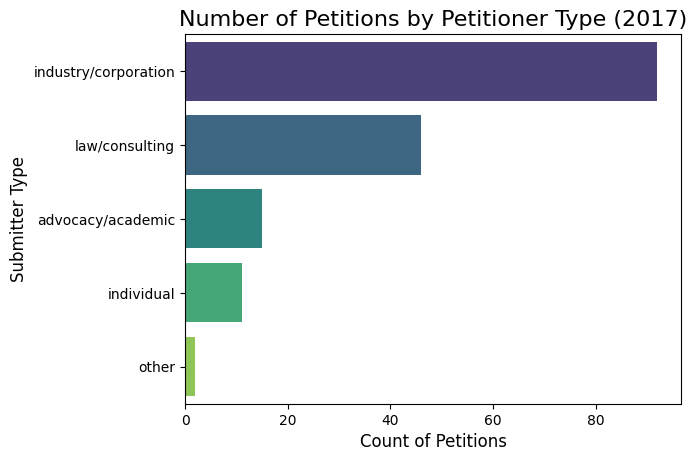

In [4]:
# IMPORTANT: only plot petitions that did not have a withdrawal letter
exclude_withdrawals_petit = df[df["Was_Withdrawn"] == False]
exclude_withdrawals_petit.to_csv("exclude_withdrawals_petitions.csv", index=False)

# count of petitions by submitter type 
order = exclude_withdrawals_petit["Submitter Type"].value_counts().index
sns.countplot(data = exclude_withdrawals_petit, y = "Submitter Type", order = order, palette = "viridis")
plt.title('Number of Petitions by Petitioner Type (2017)', fontsize=16)
plt.xlabel('Count of Petitions', fontsize=12)
plt.ylabel('Submitter Type', fontsize=12)

#### Quick Analysis of Bar Plot:
* most petitions are filled out by either industry/corps or law/consulting
* individuals having the least 

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_20784/2920394257.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = exclude_withdrawals_petit, x = "Response Time (Days)", y = "Submitter Type", order = order, palette = "plasma")


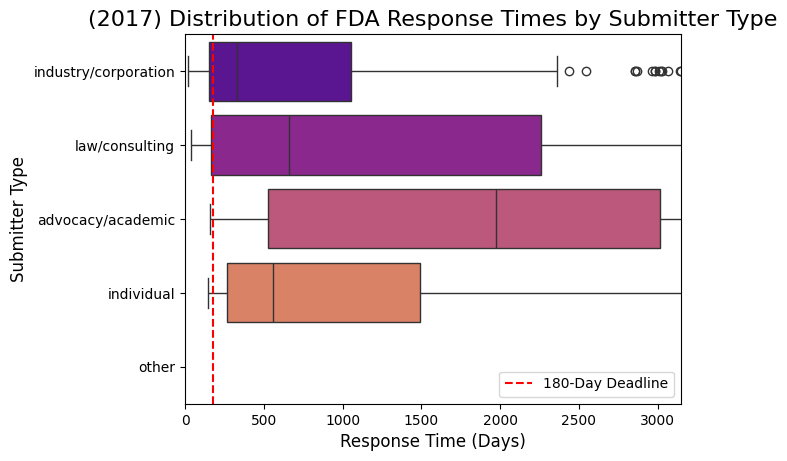

In [5]:
# response time by submitter type 
sns.boxplot(data = exclude_withdrawals_petit, x = "Response Time (Days)", y = "Submitter Type", order = order, palette = "plasma")
plt.title("(2017) Distribution of FDA Response Times by Submitter Type", fontsize=16)
plt.xlabel('Response Time (Days)', fontsize=12)
plt.ylabel('Submitter Type', fontsize=12)

# Gemini code below
# Limit x-axis to the 95th percentile for better readability, ignoring negative times
plt.xlim(0, df[df["Response Time (Days)"] >= 0]["Response Time (Days)"].quantile(0.95))
plt.axvline(x = 180, color = 'r', linestyle = '--', label = '180-Day Deadline')
plt.legend()

(Oct 8 fixed using corpus) keep in mind that other category includes individuals bc haven't figured out to separate them

#### Quick Analysis of Box Plot (Revised after recleaning data):
* median line splits the data exactly 50/50
  * industry/corp get fastest responses bc (1) median line is closes to the 180-day deadline and (2) middle 50% of data (the box) is not very spread out (compared to the others), meaning they get responses around the 180-1000 days mark (possible to extract the exact q values)
  * adv/acad have the most delayed response time from the fda bc of median line being the furthest and spread of data, followed by law/consulting
  * individual's median line and spread of data is worse than indus/consult, but better than avd/acad & law/consulting
* box itself is middle 50% (boxplot is split into 25/25/25/25 -> box is middle 50)
  * industry/corp's and individual's middle 50% of data have the least spread; data mostly around the 180-1500 deadline which is kind of good bc fda usually responds in around 180-1500 days
* dots are outliers, end of whiskers show minimum and maximum

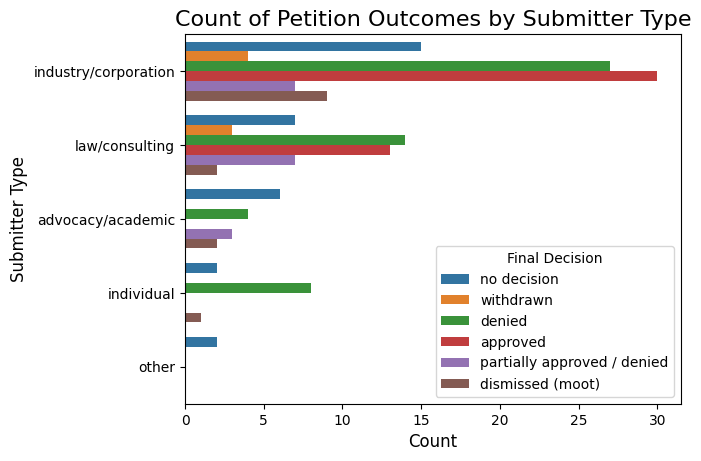

In [6]:
# stacked bar plot of count of petition final decision by submitter type
sns.countplot(data = exclude_withdrawals_petit, y = "Submitter Type", hue = "Cleaned Final Decision", order = order)

plt.title("Count of Petition Outcomes by Submitter Type", fontsize=16)
plt.xlabel("Count", fontsize=12)
plt.ylabel("Submitter Type", fontsize=12)
plt.legend(title = "Final Decision")

#### Quick Analysis:
note that each grouping is not standardized, so obviously industry/consult would have more decisions because they make up most of the petitions that were filed
* important decision to look at would be "no decsion" (blue) which is prevalents between all the categories
* adv/acad & individual not even getting any approvals, only denials or partials (but individuals not even getting partials)

#### Visualizations to prepare for inference model

Text(0.5, 1.0, 'Distribution of Response Times')

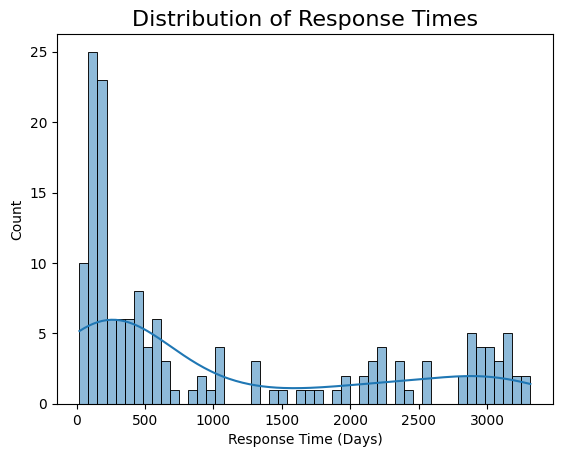

In [7]:
d = exclude_withdrawals_petit[exclude_withdrawals_petit["Response Time (Days)"] > 0]
sns.histplot(d["Response Time (Days)"].dropna(), kde = True, bins = 50)
plt.title("Distribution of Response Times", fontsize=16)

long tail stretching to the right:
* a decent amount of petitions getting super delayed response time
* supports paper because AHM was able to push forward because of long wait times



In [8]:
#exclude_withdrawals_petit[exclude_withdrawals_petit["Response Time (Days)"] <= 0]

**(FIXED) QUESTION/PROBLEM 2:** can i not consider any reconsideration petitions?
reason for negative response time:
* recall how response time is calculate
`(df["Response Time (Days)"] = (df["Last Response Date"] - df["Date of Petition"]).dt.days'`
* negative if "Last Response Date" is smaller but how can it be smaller if its the response date (responses should be after date of petition)? because of petitions that have reconsideration files (ex the two above)
* this means that the final version df has 2 rows, one with the date of actual petition and one with date of reconsideration, both have the last response date of the actual petition
* so these two specific rows above are the reconsideration files which means their dates are later/bigger compared to the "last response date" that was extracted from the actual petition


#### more analysis of distribution plot
* exploring the response times that peaked below
* conclusion for histogram: most responses take around 150-180 days which is really good bc the fda is pretty efficient for the most part, but can't exclude the heavy tail that spread all the way to 2500 days

In [9]:
stats = d["Response Time (Days)"].describe()
stats

count     160.000000
mean     1060.868750
std      1123.842237
min        20.000000
25%       160.750000
50%       432.500000
75%      2142.500000
max      3317.000000
Name: Response Time (Days), dtype: float64

In [10]:
q1 = stats["25%"]
q2 = stats["50%"]

print(f"The central peak of response times is between {q1:.0f} and {q2:.0f} days.")

peak_df = exclude_withdrawals_petit[(exclude_withdrawals_petit["Response Time (Days)"] >= q1) & 
                       (exclude_withdrawals_petit["Response Time (Days)"] <= q2)]

len(peak_df)

The central peak of response times is between 161 and 432 days.


40

#### conclusions for histogram and boxplot:
* see that there is a possible association between submitter type and shorter/longer response time -> will be a good paramter in inference model
* histogram further supports that there is a problem with fda's response time

#### further consideration for plots before modeling:
* response time vs interim
* requested action (vectorized) vs interim to see any possible association between certain "type" of petition (simpler vs complex - ask if there any suggested categories for petitions)

/var/folders/w1/yj3_r24s4tl7vlj_flvb3ntm0000gn/T/ipykernel_20784/2712651957.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data = d, x = "Count of Interim", y = "Response Time (Days)", palette = "muted")


Text(0.5, 1.0, 'Response Time vs. Number of Interim Responses')

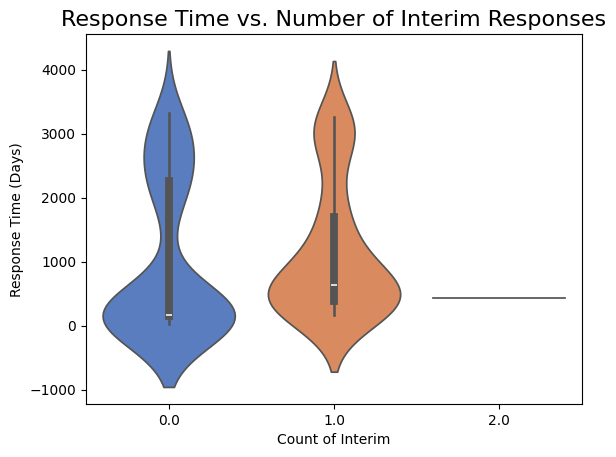

In [11]:
sns.violinplot(data = d, x = "Count of Interim", y = "Response Time (Days)", palette = "muted")
plt.title("Response Time vs. Number of Interim Responses", fontsize=16)

In [14]:
df[df["Count of Interim"] == 2]

File ID                                 Petition File Name  \
54  fda-2017-p-2229  FDA-2017-P-2229-0001_Citizen_Petition_from_Cov...   

   Date of Petition  Was_Withdrawn      Document Type  \
54       2017-04-07          False  original petition   

                  Submitter  Submitter Type  \
54  Covington & Burling LLP  law/consulting   

               Petition Cited Statutes or Regulations  \
54  - 21 C.F.R. § 10.30 – Citizen petition procedu...   

                              FDA Action Commented On  \
54  FDA’s enforcement policy concerning listing of...   

                                     Requested Action  ...    Final Decision  \
54  - Clarify that listing in the NDC Directory do...  ...  Partially Denied   

   Last Response Date Count of Interim  \
54         2018-06-13              2.0   

            Responding FDA Center (of Final Decision)  \
54  Center for Food Safety and Applied Nutrition (...   

              Responses Cited Statutes or Regulations  \
54  - 21 CFR 101.9(c)(6)(i)\n- 21 CFR 10.30\n- 21 ...   

                   Justification for Interim Response  \
54  - The FDA acknowledged receipt of the petition...   

                     Justification for Final Response Cleaned Final Decision  \
54  - The FDA emphasized that its definition of di...                 denied   

    Year Response Time (Days)  
54  2017                432.0  

[1 rows x 22 columns]

In [16]:
d[d["Response Time (Days)"] < 0]

Empty DataFrame
Columns: [File ID, Petition File Name, Date of Petition, Was_Withdrawn, Document Type, Submitter, Submitter Type, Petition Cited Statutes or Regulations, FDA Action Commented On, Requested Action, Justification for Request, Interim Response Date, Final Decision, Last Response Date, Count of Interim, Responding FDA Center (of Final Decision), Responses Cited Statutes or Regulations, Justification for Interim Response, Justification for Final Response, Cleaned Final Decision, Year, Response Time (Days)]
Index: []

[0 rows x 22 columns]

#### Quick Analysis of Violin Plot:
* entire violin for 1 interim response is positioned much higher on the plot than the violin for 0; this means the response times for 1 interim are generally much longer (supports NO interim = shorter response time)
* box for the data that had 1 interim shows that most of the data get less variability in response times than those with no interim bc of the spread (supports YES interim = shorter response time)
* however the median line for those with 0 interim shows that they get a faster median response time compared to 1 interim (supports NO interim = shorter response time)
* once again the problem is the long tail that goes nearly all the way to 4000 for both interims

so this means that there is conflicting info on whether getting an interim or not will result in longer/shorter waitimes 
